# FloPy
## MODPATH example

This notebook demonstrates how to create and run forward and backward tracking with MODPATH. The notebooks also shows how to create subsets of pathline and endpoint information, plot MODPATH results on ModelMap objects, and export endpoints and pathlines as shapefiles.

In [5]:
%matplotlib inline
import sys
import shutil
import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pandas version: {}'.format(pd.__version__))
print('flopy version: {}'.format(flopy.__version__))

if not os.path.exists("temp"):
    os.mkdir("temp")

3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
numpy version: 1.13.1
matplotlib version: 2.0.2
pandas version: 0.20.3
flopy version: 3.2.6


### Copy modflow datasets to scratch directory

In [6]:
mffiles = glob.glob(os.path.join('../','data','mp6','EXAMPLE.*'))
for f in mffiles:
    print(f)
    shutil.copy(f, os.path.join('temp', os.path.split(f)[-1]))

../data/mp6/EXAMPLE.BA6
../data/mp6/EXAMPLE.BUD
../data/mp6/EXAMPLE.DIS
../data/mp6/EXAMPLE.DIS.metadata
../data/mp6/EXAMPLE.HED
../data/mp6/EXAMPLE.LPF
../data/mp6/EXAMPLE.LST
../data/mp6/EXAMPLE.MPBAS
../data/mp6/EXAMPLE.mpnam
../data/mp6/EXAMPLE.nam
../data/mp6/EXAMPLE.OC
../data/mp6/EXAMPLE.PCG
../data/mp6/EXAMPLE.RCH
../data/mp6/EXAMPLE.RIV
../data/mp6/EXAMPLE.WEL


###Load MODFLOW model

In [8]:
model_ws = 'temp'
m = flopy.modflow.Modflow.load('EXAMPLE.nam', model_ws=model_ws)
m.get_package_list()

['DIS', 'BAS6', 'WEL', 'RIV', 'RCH', 'OC', 'PCG', 'LPF']

In [9]:
nrow, ncol, nlay, nper = m.nrow_ncol_nlay_nper
nrow, ncol, nlay, nper 

(25, 25, 5, 3)

In [10]:
m.dis.steady.array

array([ True, False,  True], dtype=bool)

In [11]:
m.write_input()

In [12]:
hdsfile = flopy.utils.HeadFile(os.path.join(model_ws,'EXAMPLE.HED'))
hdsfile.get_kstpkper()

[(0, 0),
 (0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (0, 2)]

In [13]:
hds = hdsfile.get_data(kstpkper=(0, 2))

### Plot RIV bc and head results

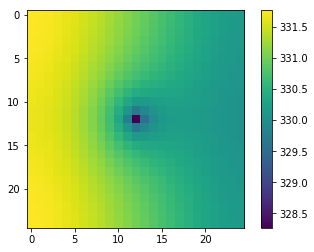

In [14]:
plt.imshow(hds[4, :, :])
plt.colorbar();

<a list of 5 text.Text objects>

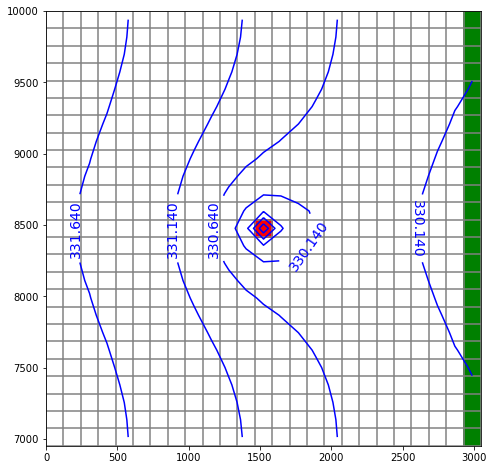

In [15]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=m, layer=4)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()
riv = modelmap.plot_bc('RIV', color='g', plotAll=True)
quadmesh = modelmap.plot_bc('WEL', kper=1, plotAll=True)
contour_set = modelmap.contour_array(hds, 
                                     levels=np.arange(np.min(hds),np.max(hds),0.5), colors='b')
plt.clabel(contour_set, inline=1, fontsize=14)

## Create forward particle tracking simulation where particles are released at the top of each cell in layer 1
* specifying the recharge package in ```create_mpsim``` releases a single particle on iface=6 of each top cell  
* start the particles at begining of per 3, step 1, as in example 3 in MODPATH6 manual

In [16]:
mp = flopy.modpath.Modpath(modelname='ex6',
                           exe_name='mp6',
                           modflowmodel=m,
                           model_ws='temp',
                           dis_file=m.name+'.dis',
                           head_file=m.name+'.hed',
                           budget_file=m.name+'.bud')

mpb = flopy.modpath.ModpathBas(mp, hdry=m.lpf.hdry, laytyp=m.lpf.laytyp, ibound=1, prsity=0.1)

# start the particles at begining of per 3, step 1, as in example 3 in MODPATH6 manual
# (otherwise particles will all go to river)
sim = mp.create_mpsim(trackdir='forward', simtype='pathline', packages='RCH', start_time=(2, 0, 1.))
mp.write_input()

mp.run_model(silent=False)

FloPy is using the following executable to run the model: /Users/jeremyw/bin/mp6
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     3.  Time =  4.10000E+05                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.


(True, [])

### Read in the endpoint file and plot particles that terminated in the well

In [18]:
epobj = flopy.utils.EndpointFile(os.path.join('temp','ex6.mpend'))
well_epd = epobj.get_destination_endpoint_data(dest_cells=[(4, 12, 12)]) 
# returns record array of same form as epobj.get_all_data()

/Users/jeremyw/miniconda3/lib/python3.6/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


In [19]:
well_epd[0:2]

rec.array([ (50, 0, 2,  0.,  29565.61914062, 1, 0, 2, 0, 6, 1,  0.5,  0.5,  1.,  200.,  9000.,  339.12310791, 1, 4, 12, 12, 2, 1,  1.        ,  0.91788489,  0.09755219,  5200.        ,  5167.15380859,   9.75521946, b'rch'),
           (75, 0, 2,  0.,  26106.58984375, 1, 0, 3, 0, 6, 1,  0.5,  0.5,  1.,  200.,  8600.,  339.12030029, 1, 4, 12, 12, 4, 1,  0.78487778,  1.        ,  0.13873141,  5113.95117188,  5200.        ,  13.87314034, b'rch')], 
          dtype=[('particleid', '<i8'), ('particlegroup', '<i8'), ('status', '<i8'), ('initialtime', '<f4'), ('finaltime', '<f4'), ('initialgrid', '<i8'), ('k0', '<i8'), ('i0', '<i8'), ('j0', '<i8'), ('initialcellface', '<i8'), ('initialzone', '<i8'), ('xloc0', '<f4'), ('yloc0', '<f4'), ('zloc0', '<f4'), ('x0', '<f4'), ('y0', '<f4'), ('z0', '<f4'), ('finalgrid', '<i8'), ('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('finalcellface', '<i8'), ('finalzone', '<i8'), ('xloc', '<f4'), ('yloc', '<f4'), ('zloc', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f

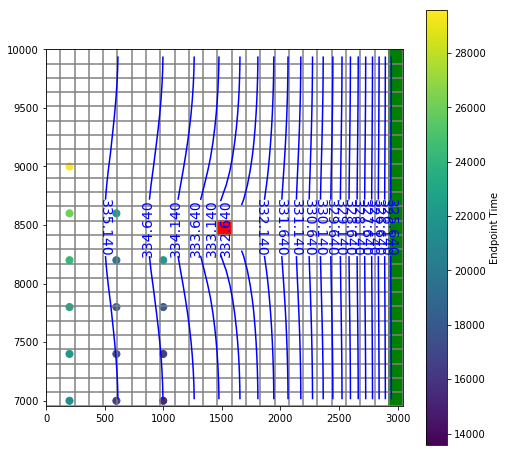

In [20]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=m, layer=2)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()
riv = modelmap.plot_bc('RIV', color='g', plotAll=True)
quadmesh = modelmap.plot_bc('WEL', kper=1, plotAll=True)
contour_set = modelmap.contour_array(hds, 
                                     levels=np.arange(np.min(hds),np.max(hds),0.5), colors='b')
plt.clabel(contour_set, inline=1, fontsize=14)
modelmap.plot_endpoint(well_epd, direction='starting', colorbar=True)

### Write starting locations to a shapefile

In [22]:
epobj.write_shapefile(well_epd, direction='starting', shpname=os.path.join('temp','starting_locs.shp'), sr=m.sr)

wrote temp/starting_locs.shp


### Read in the pathline file and subset to pathlines that terminated in the well  

In [23]:
# make a selection of cells that terminate in the well cell = (4, 12, 12)
pthobj = flopy.utils.PathlineFile(os.path.join('temp','ex6.mppth'))
well_pathlines = pthobj.get_destination_pathline_data(dest_cells=[(4, 12, 12)])
well_pathlines # this is a record array of same form as pthobj._data

/Users/jeremyw/miniconda3/lib/python3.6/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


rec.array([ ( 50, 0,  0, 12,   0.00000000e+00,   200.        ,  9000.        ,  339.12310791, 0,  2,  0, 1,  0.5       ,  0.5       ,  1.        , 0),
           ( 50, 0, -1, 12,   1.00000000e+00,   200.02200317,  8999.99707031,  339.0539856 , 0,  2,  0, 1,  0.50005507,  0.49999261,  0.99900001, 1),
           ( 50, 0,  1, 12,   1.00000000e+00,   200.02200317,  8999.99707031,  339.0539856 , 0,  2,  0, 1,  0.50005507,  0.49999261,  0.99900001, 0),
           ...,
           (550, 0, -1, 12,   2.95442305e+04,  5332.03808594,  4800.        ,   10.6032896 , 4, 12, 13, 1,  0.33009431,  0.        ,  0.1060329 , 1),
           (550, 0, -1, 12,   2.95669492e+04,  5200.        ,  4832.8828125 ,    9.75486374, 4, 12, 12, 1,  1.        ,  0.0822077 ,  0.09754863, 1),
           (550, 0, -1, 12,   2.95669492e+04,  5200.        ,  4832.8828125 ,    9.75486374, 4, 12, 12, 1,  1.        ,  0.0822077 ,  0.09754863, 1)], 
          dtype=[('particleid', '<i8'), ('particlegroup', '<i8'), ('timepointinde

### Plot the pathlines that terminate in the well and the starting locations of the particles

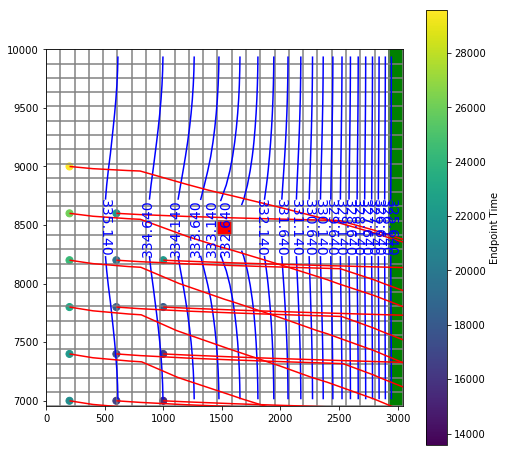

In [24]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=m, layer=2)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()
riv = modelmap.plot_bc('RIV', color='g', plotAll=True)
quadmesh = modelmap.plot_bc('WEL', kper=1, plotAll=True)
contour_set = modelmap.contour_array(hds, 
                                     levels=np.arange(np.min(hds),np.max(hds),0.5), colors='b')
plt.clabel(contour_set, inline=1, fontsize=14)

modelmap.plot_endpoint(well_epd, direction='starting', colorbar=True)
# for now, each particle must be plotted individually 
#(plot_pathline() will plot a single line for recarray with multiple particles)
for pid in np.unique(well_pathlines.particleid):
    modelmap.plot_pathline(pthobj.get_data(pid), layer='all', colors='red');

### Write pathlines to a shapefile  

In [25]:
# one line feature per particle
pthobj.write_shapefile(well_pathlines,
                       direction='starting', shpname=os.path.join('temp','pathlines.shp'))

# one line feature for each row in pathline file 
# (can be used to color lines by time or layer in a GIS)
pthobj.write_shapefile(well_pathlines, one_per_particle=False, 
                       shpname=os.path.join('temp','pathlines_1per.shp'))

wrote temp/pathlines.shp
wrote temp/pathlines_1per.shp


## Replace WEL package with MNW2; create backward tracking simulation using particles released at MNW well

In [26]:
model_ws = 'temp'
m2 = flopy.modflow.Modflow.load('EXAMPLE.nam', model_ws=model_ws, exe_name='mf2005')
m2.get_package_list()

['DIS', 'BAS6', 'WEL', 'RIV', 'RCH', 'OC', 'PCG', 'LPF']

In [27]:
m2.nrow_ncol_nlay_nper

(25, 25, 5, 3)

In [28]:
m2.wel.stress_period_data.data

{0: 0, 1: rec.array([(4, 12, 12, -150000.,  0.)], 
           dtype=[('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('flux', '<f4'), ('iface', '<f4')]), 2: rec.array([(4, 12, 12, -150000.,  0.)], 
           dtype=[('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('flux', '<f4'), ('iface', '<f4')])}

In [29]:
node_data = np.array([(3, 12, 12, 'well1', 'skin', -1, 0, 0, 0, 1., 2., 5., 6.2),
                      (4, 12, 12, 'well1', 'skin', -1, 0, 0, 0, 0.5, 2., 5., 6.2)], 
                     dtype=[('k', np.int), ('i', np.int), ('j', np.int), 
                            ('wellid', np.object), ('losstype', np.object), 
                            ('pumploc', np.int), ('qlimit', np.int), 
                            ('ppflag', np.int), ('pumpcap', np.int), 
                            ('rw', np.float), ('rskin', np.float), 
                            ('kskin', np.float), ('zpump', np.float)]).view(np.recarray)

stress_period_data = {0: np.array([(0, 'well1', -150000.0)], dtype=[('per', np.int), ('wellid', np.object), 
                                                            ('qdes', np.float)])}

In [30]:
m2.name = 'Example_mnw'
m2.remove_package('WEL')
mnw2 = flopy.modflow.ModflowMnw2(model=m2, mnwmax=1,
                                 node_data=node_data, 
                                 stress_period_data=stress_period_data, 
                                 itmp=[1, -1, -1])
m2.get_package_list()

['DIS', 'BAS6', 'RIV', 'RCH', 'OC', 'PCG', 'LPF', 'MNW2']

### Write and run MODFLOW

In [31]:
m2.write_input()

m2.run_model(silent=False)

FloPy is using the following executable to run the model: /Users/jeremyw/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 x/x/2015                        

 Using NAME file: Example_mnw.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2017/11/08 10:10:52

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Gr

(True, [])

### Create new MODPATH object

In [32]:
mp = flopy.modpath.Modpath(modelname='ex6mnw',
                           exe_name='mp6',
                           modflowmodel=m2,
                           model_ws='temp',
                           dis_file=m.name+'.dis',
                           head_file=m.name+'.hds',
                           budget_file=m.name+'.cbc')

mpb = flopy.modpath.ModpathBas(mp, hdry=m2.lpf.hdry, laytyp=m2.lpf.laytyp, ibound=1, prsity=0.1)
sim = mp.create_mpsim(trackdir='backward', simtype='pathline', packages='MNW2')

mp.write_input()

mp.run_model(silent=False)

FloPy is using the following executable to run the model: /Users/jeremyw/bin/mp6
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  2.00000E+05                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.


(True, [])

### Read in results and plot

In [33]:
pthobj = flopy.utils.PathlineFile(os.path.join('temp','ex6mnw.mppth'))
epdobj = flopy.utils.EndpointFile(os.path.join('temp','ex6mnw.mpend'))
well_epd = epdobj.get_alldata()
well_pathlines = pthobj.get_alldata() # returns a list of recarrays; one per pathline

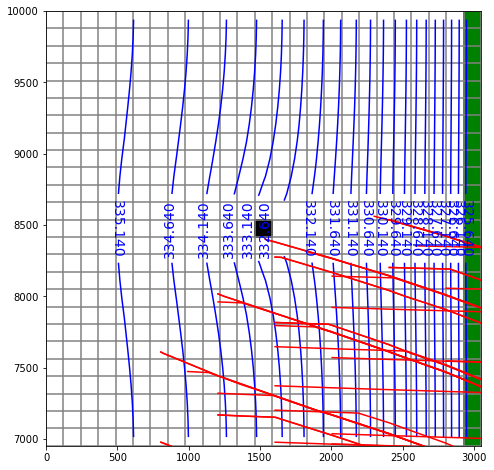

In [34]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=m2, layer=2)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()
riv = modelmap.plot_bc('RIV', color='g', plotAll=True)
quadmesh = modelmap.plot_bc('MNW2', kper=1, plotAll=True)
contour_set = modelmap.contour_array(hds, 
                                     levels=np.arange(np.min(hds),np.max(hds),0.5), colors='b')
plt.clabel(contour_set, inline=1, fontsize=14)

modelmap.plot_pathline(well_pathlines, travel_time='<10000',
                       layer='all', colors='red');